## Setup and Imports

In [12]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import random

# Set random seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print("✅ All imports successful!")

✅ All imports successful!


## Configuration and Data Loading

In [13]:
# Configuration
BATCH_SIZE = 16
MODEL_NAME = 'vit_small_patch16_224'
MODEL_PATH = 'vit_small_model.pth'

# Data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
test_dir = 'vit_data/test'
test_dataset = datasets.ImageFolder(test_dir, data_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

class_names = test_dataset.classes
num_classes = len(class_names)

print(f"📊 Dataset Information:")
print(f"   - Test samples: {len(test_dataset)}")
print(f"   - Number of classes: {num_classes}")

📊 Dataset Information:
   - Test samples: 5923
   - Number of classes: 17


## Load Trained Model

In [14]:
# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create model
model = timm.create_model(MODEL_NAME, pretrained=False, drop_rate=0.2)
num_ftrs = model.head.in_features
model.head = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, num_classes)
)

# Load weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

print("✅ Model loaded successfully!")

Using device: cpu
✅ Model loaded successfully!


## Helper Functions

In [15]:
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize image tensor for visualization"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

def get_sample_image(dataset, class_name=None, idx=None):
    """Get image from dataset by class name or index"""
    if idx is not None:
        img_path, label = dataset.samples[idx]
    elif class_name:
        class_idx = dataset.classes.index(class_name)
        indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]
        idx = random.choice(indices)
        img_path, label = dataset.samples[idx]
    else:
        idx = random.randint(0, len(dataset) - 1)
        img_path, label = dataset.samples[idx]
    
    img = Image.open(img_path).convert('RGB')
    return img, label, img_path, idx

print("✅ Helper functions loaded")

✅ Helper functions loaded


## Model Evaluation

In [16]:
# Evaluate model
model.eval()
all_preds = []
all_labels = []
all_probs = []

print("📊 Evaluating model on test set...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"\n🎯 Test Results:")
print(f"   - Accuracy: {accuracy:.4f}")
print(f"   - F1 Score (macro): {f1:.4f}")

📊 Evaluating model on test set...


Testing: 100%|██████████| 371/371 [11:10<00:00,  1.81s/it]


🎯 Test Results:
   - Accuracy: 0.9867
   - F1 Score (macro): 0.9864


## Install SHAP Library

In [17]:
!pip install shap -q
import shap
print("✅ SHAP library installed and imported")

✅ SHAP library installed and imported


## Initialize DeepSHAP/GradientSHAP

GradientSHAP works better with Vision Transformers than DeepSHAP.
We'll use a small background dataset for efficiency.

In [18]:
# Prepare background data for SHAP
print("⏳ Initializing GradientSHAP explainer...")
print("   Using GradientSHAP (optimized for Vision Transformers)\n")

background_size = 20  # Reduced for faster computation
background_data = []

# Collect background samples
for i in tqdm(range(min(background_size, len(test_dataset))), desc="Loading background"):
    img, _ = test_dataset[i]
    background_data.append(img.unsqueeze(0))

background = torch.cat(background_data, dim=0).to(device)

# Create GradientSHAP explainer
explainer = shap.GradientExplainer(model, background)

print(f"\n✅ GradientSHAP explainer initialized with {background_size} background samples")

⏳ Initializing GradientSHAP explainer...
   Using GradientSHAP (optimized for Vision Transformers)



Loading background: 100%|██████████| 20/20 [00:00<00:00, 168.19it/s]



✅ GradientSHAP explainer initialized with 20 background samples


## SHAP Analysis: Basic Examples

🧠 Computing SHAP values (this may take a few minutes)...



Processing samples:   0%|          | 0/4 [00:00<?, ?it/s]

SHAP values shape: (1, 3, 224, 224, 17)


Processing samples:  25%|██▌       | 1/4 [06:08<18:24, 368.23s/it]


KeyboardInterrupt: 

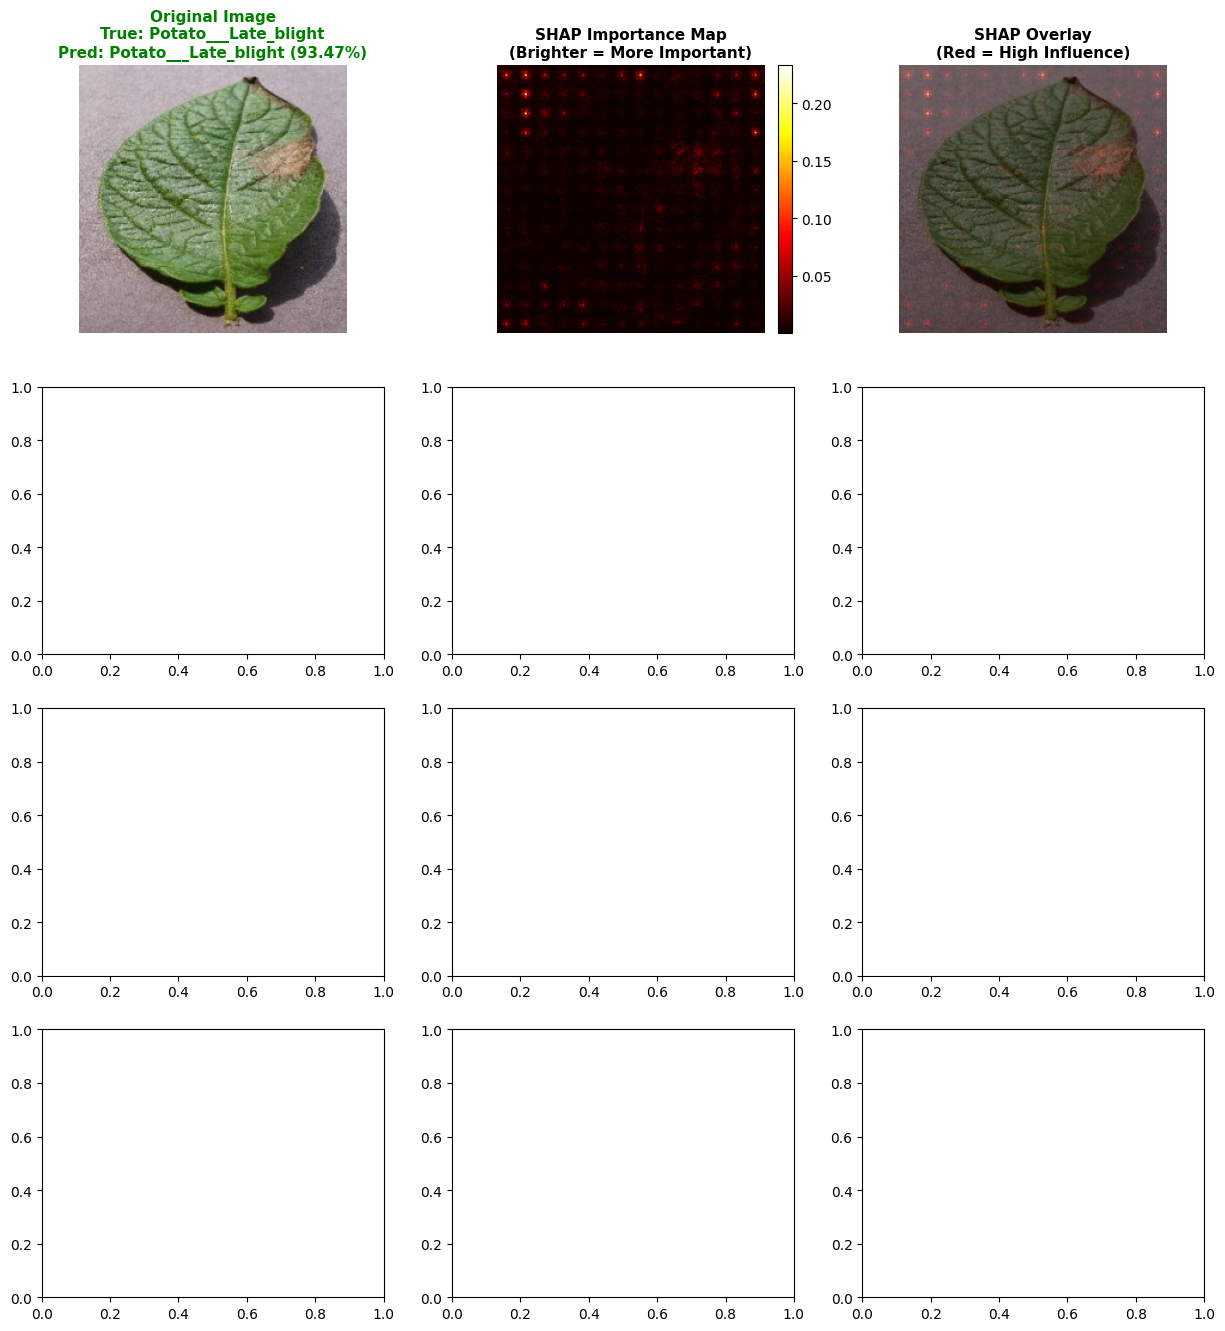

In [19]:
# Generate SHAP explanations for sample images
num_samples = 4
fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))
if num_samples == 1:
    axes = axes.reshape(1, -1)
print("🧠 Computing SHAP values (this may take a few minutes)...\n")

for idx in tqdm(range(num_samples), desc="Processing samples"):
    # Get a random test image
    img, label, img_path, _ = get_sample_image(test_dataset)
    
    # Preprocess for model
    input_tensor = data_transforms(img).unsqueeze(0).to(device)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        pred_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, pred_class].item()
    
    # Compute SHAP values
    shap_values = explainer.shap_values(input_tensor, nsamples=50)
    
    # Debug: Print shape to understand the output
    if idx == 0:
        print(f"SHAP values shape: {shap_values.shape if not isinstance(shap_values, list) else [v.shape for v in shap_values[:2]]}")
    
    # Process SHAP values - handle different return formats
    if isinstance(shap_values, list):
        # List of arrays (one per class)
        shap_numpy = shap_values[pred_class]
    else:
        # Single array - check if it has class dimension
        shap_numpy = shap_values
    
    # Convert to 2D heatmap by summing across channels
    if len(shap_numpy.shape) == 5:
        # Shape: (batch, channels, height, width, num_classes) - extract predicted class
        shap_heatmap = np.abs(shap_numpy[0, :, :, :, pred_class]).sum(axis=0)
    elif len(shap_numpy.shape) == 4:
        # Check if last dimension is num_classes or if it's (batch, channels, height, width)
        if shap_numpy.shape[-1] == num_classes:
            # Shape has class dimension at the end
            if shap_numpy.shape[0] == 1:
                shap_heatmap = np.abs(shap_numpy[0, :, :, pred_class])
            else:
                shap_heatmap = np.abs(shap_numpy[:, :, :, pred_class]).sum(axis=0)
        else:
            # Shape: (batch, channels, height, width)
            shap_heatmap = np.abs(shap_numpy[0]).sum(axis=0)
    elif len(shap_numpy.shape) == 3:
        # Shape: (channels, height, width)
        shap_heatmap = np.abs(shap_numpy).sum(axis=0)
    else:
        # Already 2D
        shap_heatmap = np.abs(shap_numpy)
    
    # Denormalize image for visualization
    img_denorm = denormalize(input_tensor[0].cpu())
    img_denorm_np = img_denorm.permute(1, 2, 0).numpy()
    
    # Plot original image
    axes[idx, 0].imshow(img_denorm_np)
    color = 'green' if pred_class == label else 'red'
    axes[idx, 0].set_title(f'Original Image\nTrue: {class_names[label]}\nPred: {class_names[pred_class]} ({confidence:.2%})', 
                           fontsize=11, fontweight='bold', color=color)
    axes[idx, 0].axis('off')
    
    # Plot SHAP importance heatmap
    im = axes[idx, 1].imshow(shap_heatmap, cmap='hot', interpolation='bilinear')
    axes[idx, 1].set_title('SHAP Importance Map\n(Brighter = More Important)', 
                           fontsize=11, fontweight='bold')
    axes[idx, 1].axis('off')
    plt.colorbar(im, ax=axes[idx, 1], fraction=0.046, pad=0.04)
    
    # Plot overlay
    axes[idx, 2].imshow(img_denorm_np)
    axes[idx, 2].imshow(shap_heatmap, cmap='hot', alpha=0.5, interpolation='bilinear')
    axes[idx, 2].set_title('SHAP Overlay\n(Red = High Influence)', 
                           fontsize=11, fontweight='bold')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.suptitle('SHAP Analysis: Pixel-Level Feature Importance', 
             fontsize=18, fontweight='bold', y=1.001)
plt.show()

print("\n💡 Interpretation:")
print("   - Brighter regions have more influence on the model's prediction")
print("   - Red/warm colors in overlay show pixels that drive the decision")

## Detailed SHAP Analysis: Single Image with Top Predictions

🎯 Generating detailed SHAP analysis...

Computing SHAP values (this will take 2-3 minutes)...


TypeError: Invalid shape (1, 3, 224, 224, 17) for image data

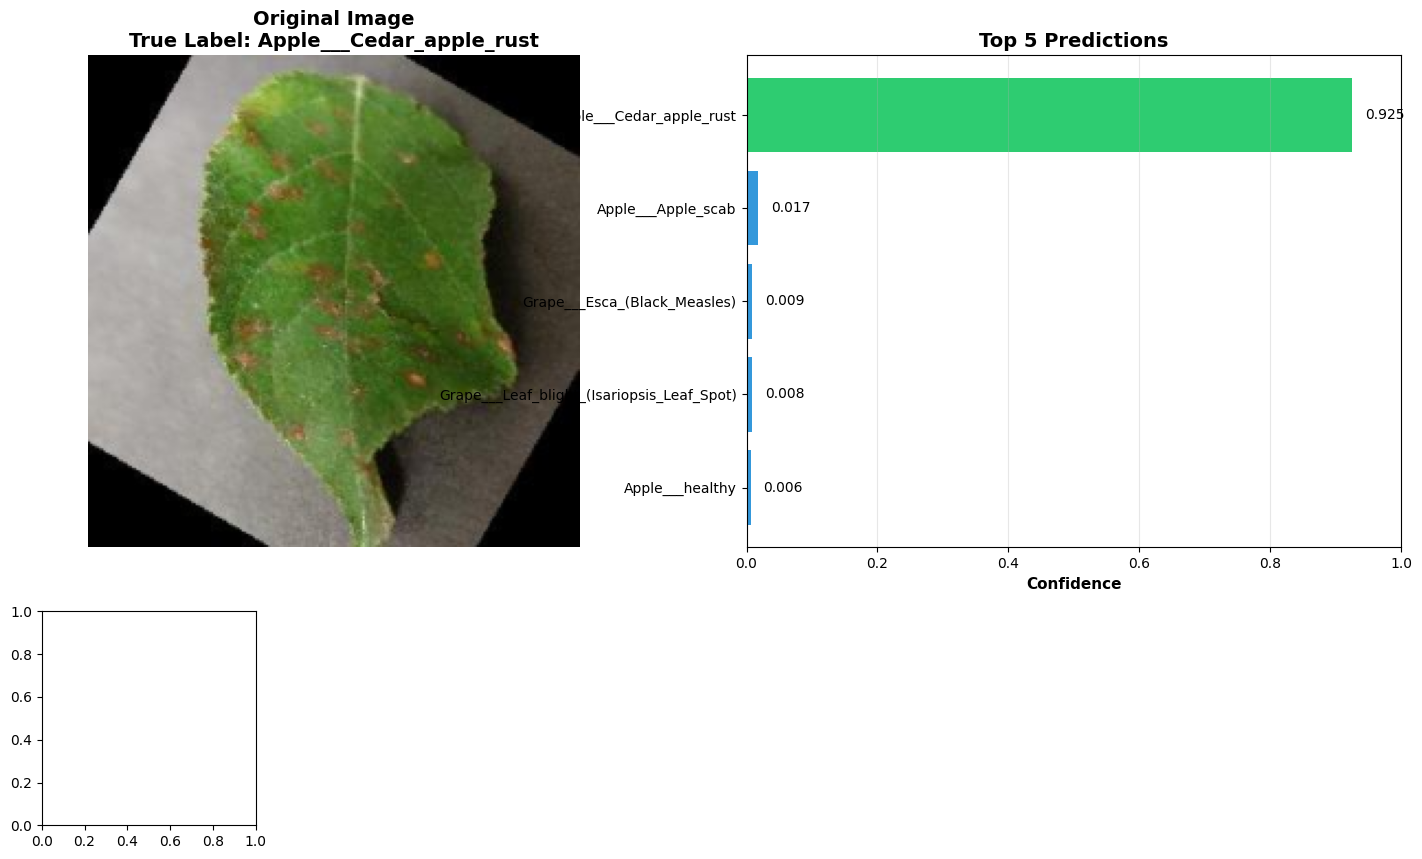

In [ ]:
# Detailed SHAP analysis for one image showing multiple class predictions
print("🎯 Generating detailed SHAP analysis...\n")
img, label, img_path, _ = get_sample_image(test_dataset)

# Preprocess
input_tensor = data_transforms(img).unsqueeze(0).to(device)

# Get predictions
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.softmax(output, dim=1)
    pred_class = torch.argmax(probabilities, dim=1).item()
    top5_probs, top5_indices = torch.topk(probabilities[0], 5)

# Compute SHAP values
print("Computing SHAP values (this will take 2-3 minutes)...")
shap_values = explainer.shap_values(input_tensor, nsamples=100)

# Prepare visualization
img_denorm = denormalize(input_tensor[0].cpu())
img_denorm_np = img_denorm.permute(1, 2, 0).numpy()

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Original image
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax1.imshow(img_denorm_np)
ax1.set_title(f'Original Image\nTrue Label: {class_names[label]}', 
              fontsize=14, fontweight='bold')
ax1.axis('off')

# Top 5 predictions bar chart
ax2 = fig.add_subplot(gs[0:2, 2:4])
y_pos = np.arange(5)
colors_bar = ['#2ecc71' if i == 0 else '#3498db' for i in range(5)]
ax2.barh(y_pos, top5_probs.cpu().numpy(), color=colors_bar)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([class_names[idx.item()] for idx in top5_indices])
ax2.invert_yaxis()
ax2.set_xlabel('Confidence', fontsize=11, fontweight='bold')
ax2.set_title('Top 5 Predictions', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1])
for i, v in enumerate(top5_probs.cpu().numpy()):
    ax2.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=10)
ax2.grid(axis='x', alpha=0.3)

# SHAP heatmaps for top 3 classes
for i in range(3):
    class_idx = top5_indices[i].item()
    
    # Handle SHAP values properly
    if isinstance(shap_values, list):
        sv = shap_values[class_idx]
        if len(sv.shape) == 5:
            shap_for_class = np.abs(sv[0, :, :, :, class_idx]).sum(axis=0)
        elif len(sv.shape) == 4:
            if sv.shape[-1] == num_classes:
                shap_for_class = np.abs(sv[0, :, :, class_idx]) if sv.shape[0] == 1 else np.abs(sv[:, :, :, class_idx]).sum(axis=0)
            else:
                shap_for_class = np.abs(sv[0]).sum(axis=0)
        elif len(sv.shape) == 3:
            shap_for_class = np.abs(sv).sum(axis=0)
        else:
            shap_for_class = np.abs(sv)
    else:
        if len(shap_values.shape) == 5:
            # Shape: (batch, channels, height, width, num_classes)
            shap_for_class = np.abs(shap_values[0, :, :, :, class_idx]).sum(axis=0)
        elif len(shap_values.shape) == 4:
            if shap_values.shape[-1] == num_classes:
                # Shape has class dimension at the end
                if shap_values.shape[0] == 1:
                    shap_for_class = np.abs(shap_values[0, :, :, class_idx])
                else:
                    shap_for_class = np.abs(shap_values[:, :, :, class_idx]).sum(axis=0)
            else:
                # Shape: (batch, channels, height, width)
                shap_for_class = np.abs(shap_values[0]).sum(axis=0)
        elif len(shap_values.shape) == 3:
            shap_for_class = np.abs(shap_values).sum(axis=0)
        else:
            shap_for_class = np.abs(shap_values)
    
    ax = fig.add_subplot(gs[2, i])
    im = ax.imshow(shap_for_class, cmap='hot', interpolation='bilinear')
    ax.set_title(f'{class_names[class_idx]}\n({top5_probs[i].item():.2%})', 
                 fontsize=10, fontweight='bold')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Overall SHAP importance (average across top classes)
ax4 = fig.add_subplot(gs[2, 3])
if isinstance(shap_values, list):
    # Average importance across top 3 classes
    class_importances = []
    for i in range(min(3, len(shap_values))):
        sv = shap_values[top5_indices[i].item()]
        cls_idx = top5_indices[i].item()
        if len(sv.shape) == 5:
            class_importances.append(np.abs(sv[0, :, :, :, cls_idx]).sum(axis=0))
        elif len(sv.shape) == 4:
            if sv.shape[-1] == num_classes:
                class_importances.append(np.abs(sv[0, :, :, cls_idx]) if sv.shape[0] == 1 else np.abs(sv[:, :, :, cls_idx]).sum(axis=0))
            else:
                class_importances.append(np.abs(sv[0]).sum(axis=0))
        elif len(sv.shape) == 3:
            class_importances.append(np.abs(sv).sum(axis=0))
        else:
            class_importances.append(np.abs(sv))
    overall_shap = np.mean(class_importances, axis=0)
else:
    if len(shap_values.shape) == 5:
        # Average across top 3 classes
        class_importances = []
        for i in range(min(3, len(top5_indices))):
            cls_idx = top5_indices[i].item()
            class_importances.append(np.abs(shap_values[0, :, :, :, cls_idx]).sum(axis=0))
        overall_shap = np.mean(class_importances, axis=0)
    elif len(shap_values.shape) == 4:
        if shap_values.shape[-1] == num_classes:
            # Average across top 3 classes
            class_importances = []
            for i in range(min(3, len(top5_indices))):
                cls_idx = top5_indices[i].item()
                if shap_values.shape[0] == 1:
                    class_importances.append(np.abs(shap_values[0, :, :, cls_idx]))
                else:
                    class_importances.append(np.abs(shap_values[:, :, :, cls_idx]).sum(axis=0))
            overall_shap = np.mean(class_importances, axis=0)
        else:
            overall_shap = np.abs(shap_values[0]).sum(axis=0)
    elif len(shap_values.shape) == 3:
        overall_shap = np.abs(shap_values).sum(axis=0)
    else:
        overall_shap = np.abs(shap_values)

im = ax4.imshow(overall_shap, cmap='viridis', interpolation='bilinear')
ax4.set_title('Overall Importance\n(Average)', fontsize=10, fontweight='bold')
ax4.axis('off')
plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)

plt.suptitle('Comprehensive SHAP Analysis: Class-Specific Feature Importance', 
             fontsize=18, fontweight='bold')
plt.show()

print(f"\n📋 Analysis Summary:")
print(f"   Image: {img_path}")
print(f"   True label: {class_names[label]}")
print(f"   Predicted: {class_names[pred_class]} with {top5_probs[0].item():.2%} confidence")
print(f"\n💡 Interpretation:")
print(f"   - Bottom row shows SHAP importance maps for each of the top 3 predicted classes")
print(f"   - Different classes focus on different image regions")
print(f"   - Warmer colors (red/yellow) indicate pixels that strongly influence predictions")

## SHAP Analysis by Class

Let's analyze SHAP importance patterns for specific plant disease classes.

🔬 Analyzing SHAP patterns for 4 classes...



Processing classes:   0%|          | 0/4 [00:22<?, ?it/s]


KeyboardInterrupt: 

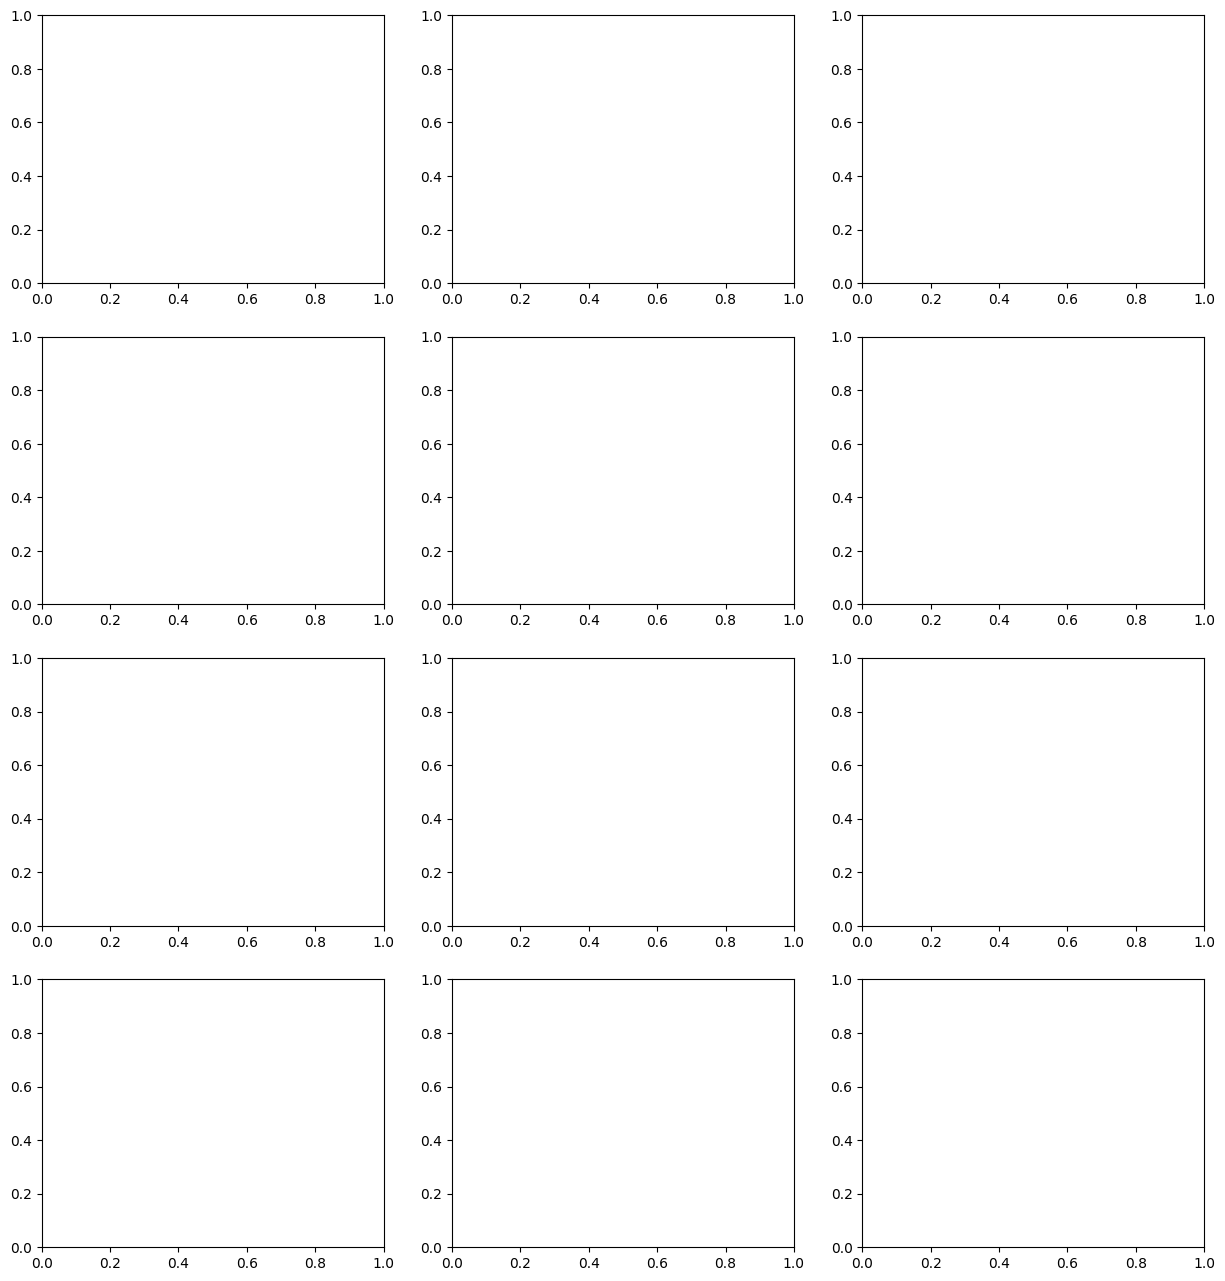

In [ ]:
# Analyze SHAP patterns for different classes
selected_classes = random.sample(class_names, min(4, len(class_names)))
fig, axes = plt.subplots(len(selected_classes), 3, figsize=(15, len(selected_classes) * 4))
if len(selected_classes) == 1:
    axes = axes.reshape(1, -1)

print(f"🔬 Analyzing SHAP patterns for {len(selected_classes)} classes...\n")

for idx, class_name in enumerate(tqdm(selected_classes, desc="Processing classes")):
    # Get sample from this class
    img, label, img_path, _ = get_sample_image(test_dataset, class_name=class_name)
    input_tensor = data_transforms(img).unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        pred_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, pred_class].item()
    
    # Compute SHAP values
    shap_values = explainer.shap_values(input_tensor, nsamples=50)
    
    # Process SHAP values
    if isinstance(shap_values, list):
        shap_numpy = shap_values[pred_class]
    else:
        shap_numpy = shap_values
    
    # Handle different shape formats
    if len(shap_numpy.shape) == 5:
        # Shape: (batch, channels, height, width, num_classes)
        shap_heatmap = np.abs(shap_numpy[0, :, :, :, pred_class]).sum(axis=0)
    elif len(shap_numpy.shape) == 4:
        if shap_numpy.shape[-1] == num_classes:
            # Shape has class dimension
            if shap_numpy.shape[0] == 1:
                shap_heatmap = np.abs(shap_numpy[0, :, :, pred_class])
            else:
                shap_heatmap = np.abs(shap_numpy[:, :, :, pred_class]).sum(axis=0)
        else:
            # Shape: (batch, channels, height, width)
            shap_heatmap = np.abs(shap_numpy[0]).sum(axis=0)
    elif len(shap_numpy.shape) == 3:
        shap_heatmap = np.abs(shap_numpy).sum(axis=0)
    else:
        shap_heatmap = np.abs(shap_numpy)
    
    # Denormalize image
    img_denorm = denormalize(input_tensor[0].cpu())
    img_denorm_np = img_denorm.permute(1, 2, 0).numpy()
    
    # Plot
    if len(selected_classes) == 1:
        axes = [axes]
    
    axes[idx][0].imshow(img_denorm_np)
    axes[idx][0].set_title(f'{class_name}\n(True Class)', 
                           fontsize=10, fontweight='bold')
    axes[idx][0].axis('off')
    
    im = axes[idx][1].imshow(shap_heatmap, cmap='hot', interpolation='bilinear')
    axes[idx][1].set_title('SHAP Importance', fontsize=10, fontweight='bold')
    axes[idx][1].axis('off')
    plt.colorbar(im, ax=axes[idx][1], fraction=0.046, pad=0.04)
    
    axes[idx][2].imshow(img_denorm_np)
    axes[idx][2].imshow(shap_heatmap, cmap='hot', alpha=0.5, interpolation='bilinear')
    color = 'green' if pred_class == label else 'red'
    axes[idx][2].set_title(f'Prediction: {class_names[pred_class]}\n({confidence:.2%})', 
                           fontsize=10, fontweight='bold', color=color)
    axes[idx][2].axis('off')

plt.tight_layout()
plt.suptitle('SHAP Analysis by Class: Understanding Feature Focus', 
             fontsize=18, fontweight='bold', y=1.001)
plt.show()

print("\n💡 Each row shows how SHAP highlights important features for different disease classes")

## Summary

**SHAP Analysis Key Insights:**

1. **Pixel-Level Attribution**: SHAP values show which specific pixels influence the model's prediction
2. **Class-Specific Patterns**: Different disease classes show different attention patterns
3. **Model Transparency**: SHAP helps verify the model focuses on relevant features (disease symptoms on leaves)
4. **Debugging Tool**: Can identify when the model focuses on wrong regions or background artifacts

**Interpretation Tips:**
- Brighter/warmer colors = higher importance
- Red regions in overlay = pixels that strongly drive the prediction
- Compare SHAP maps across classes to understand decision boundaries